## This problem was clustering texts with very differnt lengths with still remaining interpretability. We used TF-IDF method to generate training data from our texts. Quickly it turns out that methods of reducing dimensions and topic modeling will help us a lot. Our new variables we interpreted as measure of compatibility of text with topic. Finally we clustered every text with the most compatible topic to it. Result turned out to be very interesting.

In [51]:
# insted of requirments.txt file we can use this code to install all the required packages

# ! pip install wordcloud
# ! pip install gensim
# ! pip install np
# ! pip install nltp
# ! pip install enchant
# ! pip install seaborn

In [52]:
import nltk
import numpy as np
import enchant
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')      
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /Users/mat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mat/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/mat/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [53]:
warnings.filterwarnings('ignore')

In [54]:
data = []
# ścieżka do plików
p = os.path.join(os.getcwd(), 'data')
for folder in os.listdir(p):
    path = os.path.join(p, folder)
    # jeśli plik to pomiń
    if os.path.isfile(path):
        continue
    # jesli folder to pobierz pliki
    mails = os.listdir(path)
    for mail in mails:
        path = os.path.join(p, folder, mail)
        with open(path, encoding="latin-1") as file:
            text = file.read()
        data.append([text, folder])
df = pd.DataFrame(data)

In [55]:
def Preprocesing(data, lematize = True, stem = True):
    # Korzystamy naraz z lematyzacji i stemmingu by osiągnąć jak największą redukcje słów
    
    # Bierzemy wszystko po pierwszych 2 enterach czyli po opisie technicznym
    formated = data.split('\n\n')[1:]
    formated = ' '.join(formated).lower() # zamiana na małe litery
    
    # Wyrzucamy wszystkie wyrażenia słowo.słowo(ścieżki itp.) i adresy mail 
    formated = re.sub('((\w+\.)+\w+)|\w+@\w+','', formated)
    
    # Podmieniamy wszystkie liczby, ciągi liczb na spacje  i "_"
    formated =re.sub('\W|\d|_'," ", formated)
    
    # Tokenizacja
    tokenizer = RegexpTokenizer(r"\w+")
    formated= tokenizer.tokenize(formated)
    
    # Usuwamy stop wordsy
    stop_words = set(stopwords.words('english'))
    formated = [word for word in formated if (not word in stop_words) and len(word) > 1]
        
    # Lematyzacja
    if(lematize == True):
        lemmatizer = WordNetLemmatizer()
        formated = [lemmatizer.lemmatize(word) for word in formated] 
        
    # Stemming    
    if (stem == True):
        ps = PorterStemmer() 
        formated = [ps.stem(word) for word in formated]           

    return " ".join(formated)

In [56]:
df = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(
    df[0],
    df[1],
    test_size=0.4, random_state=213)

# Preprocesing
X_train = [Preprocesing(text) for text in X_train]
X_test = [Preprocesing(text) for text in X_test]
X_train[:5]

['dear fellow usenet user would like give formal apolog post advertis print busi intend advertis rather offer peopl usenet mani use print regular basi awar legal usenet tri put colleg request inform write privat fun flood mailbox think grow offer advic one thing use profan toward anoth thank marc bitnet',
 'articl write puzzl obviou untruth think go nissan claim altima best sell new car namelpl u think near verbatim lee iaccoca statist dept would proud sentenc note corolla prism also new design hey new namepl guess nissan even sell mani altima toyota corolla would namepl qualifi waiiiiiit nissan offici regist car far govern paperwork go nissan stanza altima avoid costli lengthi paperwork read net ago someon actual may said littl stanza logo altima somewher way spiro spiro triantafyllopoulo softwar technolog delco electron gm hugh electron kokomo post therefor armm',
 'articl com bob pita write articl brian harvey write com robbi felix write thousand kind teenag volunt local agenc help 

# Tf_idf + Kmeans

In [57]:
def Tf_idf(data, max_t = 0.20, min_t = 0.02):
    # obliczamy tf_idf i usuwamy słowa które występują w mniej niż 2% tesktów i częściej niż w 20%
    
    vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', max_df = max_t,min_df=min_t)
    tf_idf = vectorizer.fit_transform(data)
    tf_idf = pd.DataFrame(tf_idf.toarray(), columns = vectorizer.get_feature_names_out())
    return tf_idf, vectorizer

In [58]:
tf_idf, vectorizer = Tf_idf(X_train)
used_words = vectorizer.get_feature_names_out()
tf_idf

,abil,abl,absolut,accept,access,accord,account,act,action,activ,...,wors,worth,written,wrong,wrote,ye,yeah,year,york,young
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.192072,0.0,0.0,0.0,0.311916,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.120902,0.208510,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.057763,0.0,0.0,0.0,0.0,0.000000,0.287803,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11993,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
11994,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
11995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
11996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


Jak widzimy według DBSCAN nasze dane to głównie szum

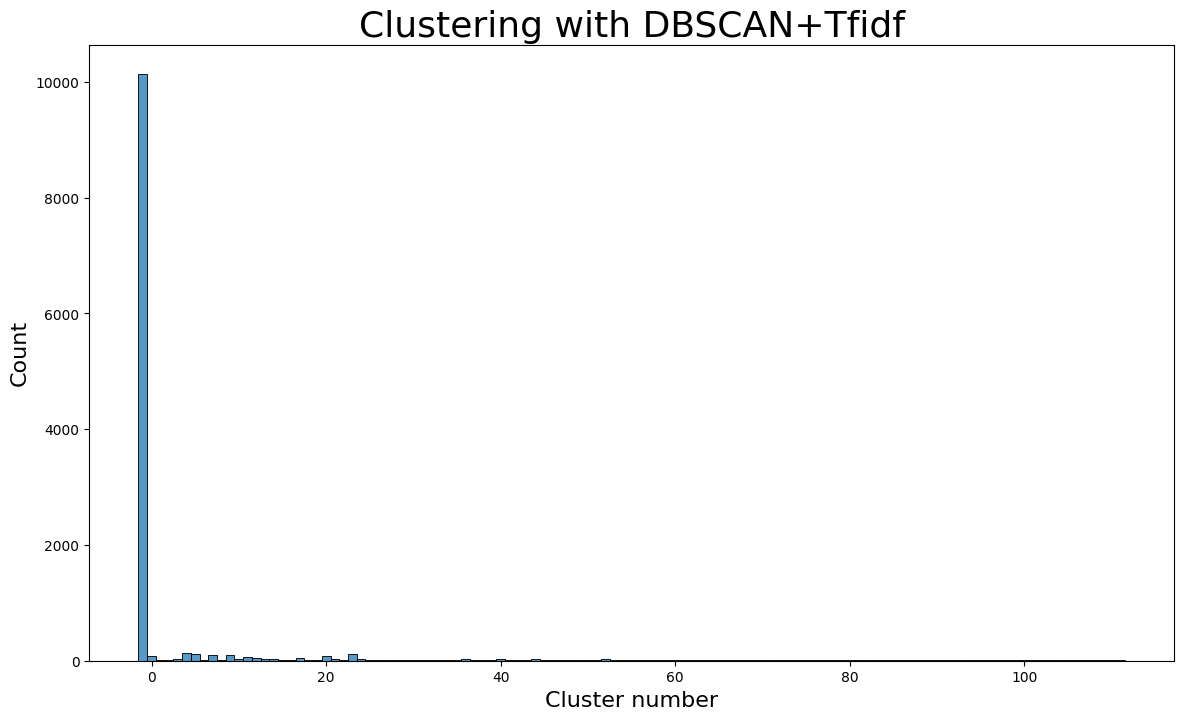

In [59]:
clustering = DBSCAN(eps =0.9).fit(tf_idf)
labels = clustering.labels_
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels, discrete= True)
plt.title("Clustering with DBSCAN+Tfidf",fontsize=26)
plt.xlabel('Cluster number',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.show()

In [60]:
# Liczenie dowolnego score dla różnych ilości klastrów i modeli
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [61]:
cluster_num_seq = range(5, 36) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(tf_idf, cluster_num_seq, KMeans, silhouette_score)

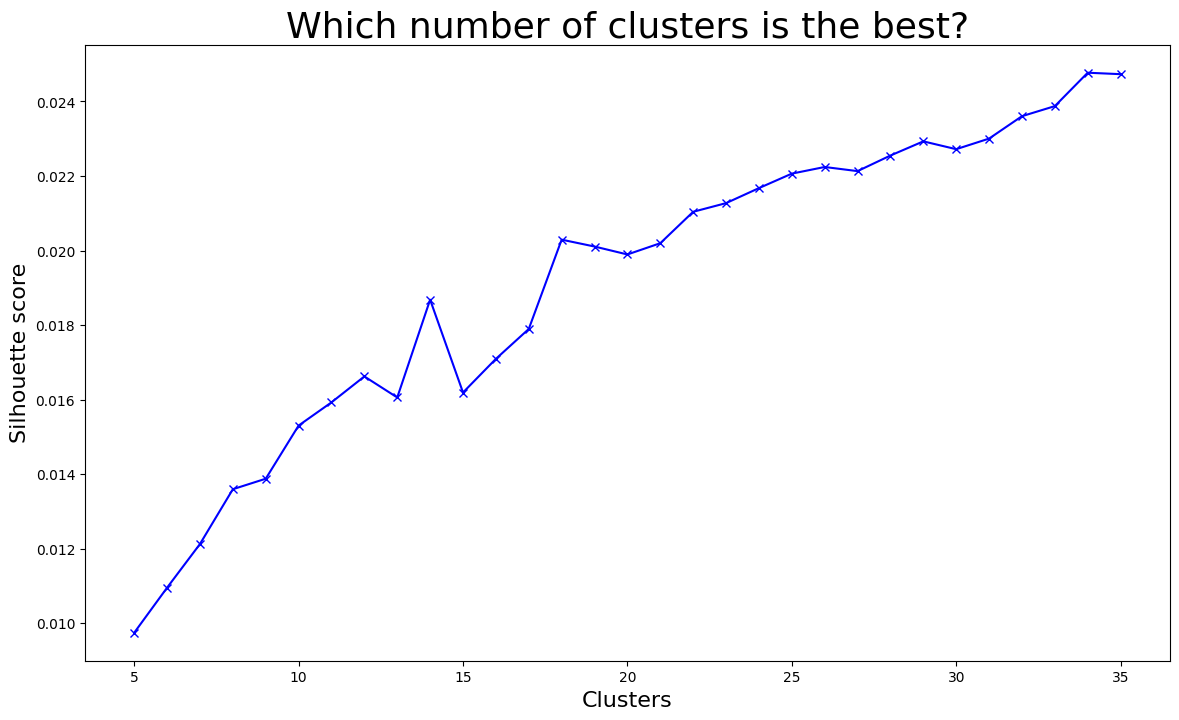

In [62]:
plt.figure(figsize=(14,8)).clf()
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.title("Which number of clusters is the best?",fontsize=26)
plt.xlabel('Clusters',fontsize=16)
plt.ylabel('Silhouette score',fontsize=16)

plt.show()

In [63]:
# Do liczenia sum of squares dla elbow method
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

In [64]:
wcss_vec = count_wcss_scores(tf_idf, len(cluster_num_seq))
x_ticks = list(range(1, len(wcss_vec) + 1))

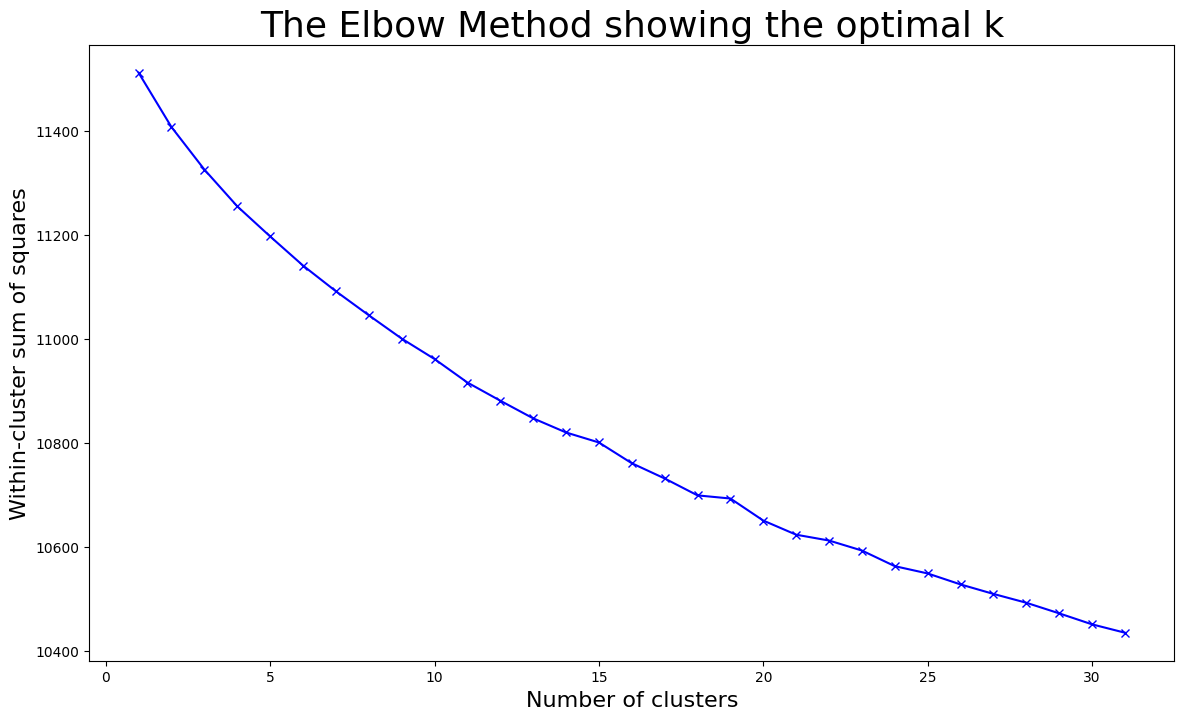

In [65]:

plt.figure(figsize=(14,8)).clf()
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('Number of clusters',fontsize=16)
plt.ylabel('Within-cluster sum of squares',fontsize=16)
plt.title('The Elbow Method showing the optimal k',fontsize=26)
plt.show()

Widać, że nie ma jakiegoś wyróżniającego się punktu, ale po 12 jest pierwszy spadek w Silhouette score. Chcemy mieć stosunkowo niewiele więc 12 jest najlepszą liczbą.

In [66]:
true_k = 12
km = KMeans(n_clusters = true_k)
km.fit(tf_idf)
labels = km.predict(tf_idf)

In [67]:
# Tworzenie crosstaba dla poglądu interpretowalności clusteringu
df = pd.DataFrame({'label': labels, 'category': y_train})
pd.crosstab(df['label'], df['category']).T

label,0,1,2,3,4,5,6,7,8,9,10,11
category,,,,,,,,,,,,
alt.atheism,3,0,262,104,0,3,45,8,1,164,0,0
comp.graphics,251,1,83,4,55,2,0,143,7,0,2,28
comp.os.ms-windows.misc,110,16,51,1,293,0,0,69,0,0,3,55
comp.sys.ibm.pc.hardware,194,113,32,0,20,2,0,108,4,1,5,114
comp.sys.mac.hardware,311,80,57,0,10,0,0,103,2,0,6,40
comp.windows.x,254,1,58,0,165,0,0,110,0,1,16,8
misc.forsale,291,54,83,0,4,30,0,97,24,0,2,30
rec.autos,40,15,153,0,3,333,13,50,0,0,3,0
rec.motorcycles,19,27,281,0,2,240,6,27,4,2,4,0


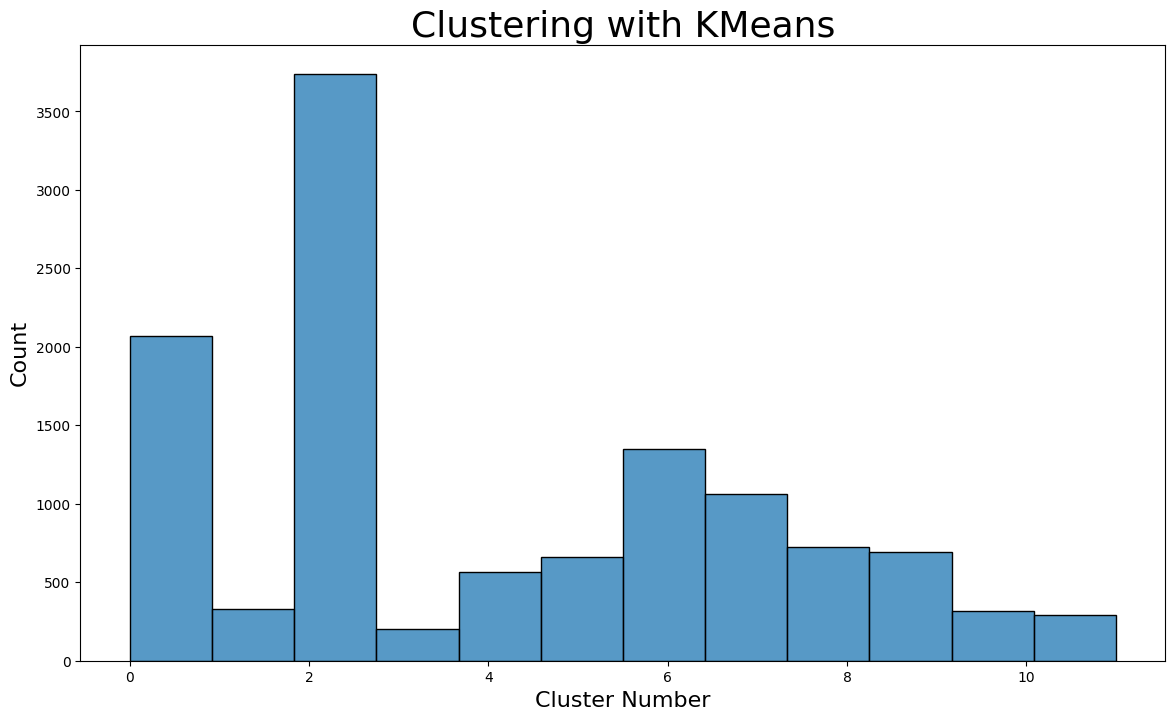

In [68]:
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels, bins = true_k)
plt.title('Clustering with KMeans',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

Centroidy powiedzą nam jakie słowa są najważniejsze dla danego klastru

In [69]:
centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :15]:
        print(' %s' % terms[ind], end='')
        
    print()

Cluster 0: comput price new problem mac softwar program imag need run space bit monitor look machin
Cluster 1: drive disk hard mb format problem control mac set comput instal softwar new need thank
Cluster 2: year com post thing good look want realli new univers read point someth day mani
Cluster 3: moral object valu frank uucp good scienc mean better truth observ right opinion subject exist
Cluster 4: window file program run applic problem thank manag version help display need tri screen set
Cluster 5: car bike ride dod engin mile good road speed look drive new buy thing right
Cluster 6: govern gun right israel law state kill fbi jew child koresh said weapon countri war
Cluster 7: thank pleas mail anyon advanc email appreci repli post help inform look hi address list
Cluster 8: game team play player win year fan season leagu good goal hit run seri watch
Cluster 9: god christian jesu believ bibl christ belief religion faith church exist love life word mean
Cluster 10: key encrypt chip 

### Jak widzimy nawet Kmeans ma problem z tworzeniem się jednego dużego klastra. Zatem zmieniamy podejście i będziemy robić topic modeling i na jego podstawie clustering.

In [70]:
# Funkcja służąca do dostania najważniejszych słów z tematów
def get_topics(model,num_topics, feat_names, n_top_words = 10):
    word_dict = {}
    
    for i in range(num_topics):
        # z składowych modeli redukcji sortujemy je po ważności i wybieramy n pierwszych
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict).T

## Redukcja po NMF

In [71]:
# Ustalimy 15 jako stałą liczbe tematów dla wszystkich metod
true_k= 15

In [72]:
model = NMF(n_components = true_k, init = 'nndsvda', max_iter = 1000, random_state = 42)
model.fit(tf_idf)
features = model.transform(tf_idf)
# Tabela najważniejszych słów dla danego tematu
get_topics(model, true_k, used_words)

,0,1,2,3,4,5,6,7,8,9
Topic # 01,govern,right,gun,law,state,israel,kill,jew,fbi,child
Topic # 02,window,run,applic,program,problem,manag,version,server,screen,driver
Topic # 03,game,play,watch,win,night,seri,fan,run,blue,goal
Topic # 04,god,christian,jesu,believ,bibl,christ,faith,church,religion,love
Topic # 05,drive,disk,hard,mb,control,problem,format,mac,instal,set
Topic # 06,thank,pleas,mail,anyon,advanc,email,appreci,repli,hi,post
Topic # 07,key,chip,encrypt,secur,phone,bit,public,govern,number,data
Topic # 08,car,engin,speed,mile,look,model,buy,good,driver,road
Topic # 09,card,driver,video,monitor,bit,bu,color,mb,board,graphic
Topic # 10,thing,problem,tri,someth,realli,post,want,good,com,read


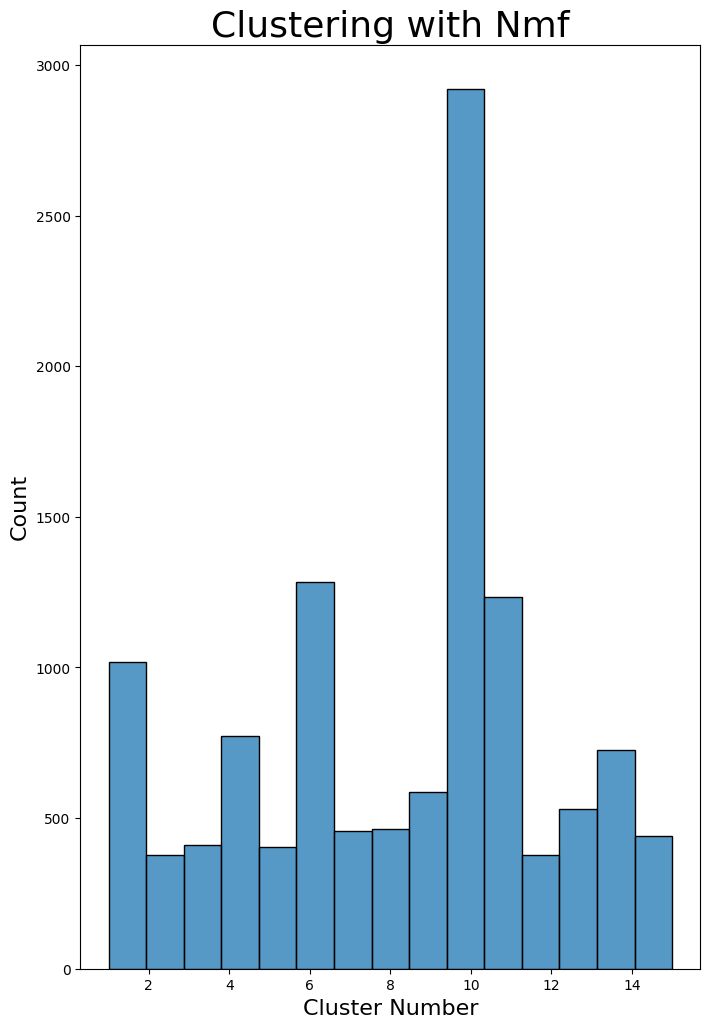

In [73]:
# Przypisujemy najważniejszy temat jako klaster 
topic = [np.argmax(values)+1 for values in features]

plt.figure(figsize=(8,12)).clf()
topics = pd.DataFrame({'Clusters' : topic})

# Tworzymy histogram by sprawdzić jak metoda radzi sobie z nadmiernym skupianiem się wokół jednego klastra
sns.histplot(topics, bins = true_k, x = 'Clusters')
plt.title('Clustering with Nmf',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

## Redukcja po LDA (latent dirichlet allocation)

In [74]:
lda = LDA(n_components=true_k, random_state=42)
lda.fit(tf_idf)
lda_features = lda.transform(tf_idf)
get_topics(lda, true_k, used_words)

,0,1,2,3,4,5,6,7,8,9
Topic # 01,sale,offer,ship,price,sell,condit,ask,new,includ,pleas
Topic # 02,window,card,file,run,problem,program,bit,color,monitor,graphic
Topic # 03,drive,mb,disk,hard,switch,mac,format,control,suppli,problem
Topic # 04,moral,object,valu,frank,uucp,good,mean,observ,scienc,better
Topic # 05,server,dod,ride,test,event,defin,road,request,steve,apr
Topic # 06,israel,jew,kill,war,jewish,govern,nation,peac,state,polit
Topic # 07,rd,st,tax,red,blue,michael,april,new,class,face
Topic # 08,game,team,play,player,fan,year,win,season,hit,leagu
Topic # 09,mail,thank,pleas,email,univers,anyon,internet,fax,address,inform
Topic # 10,gun,govern,law,right,fbi,weapon,state,koresh,pay,want


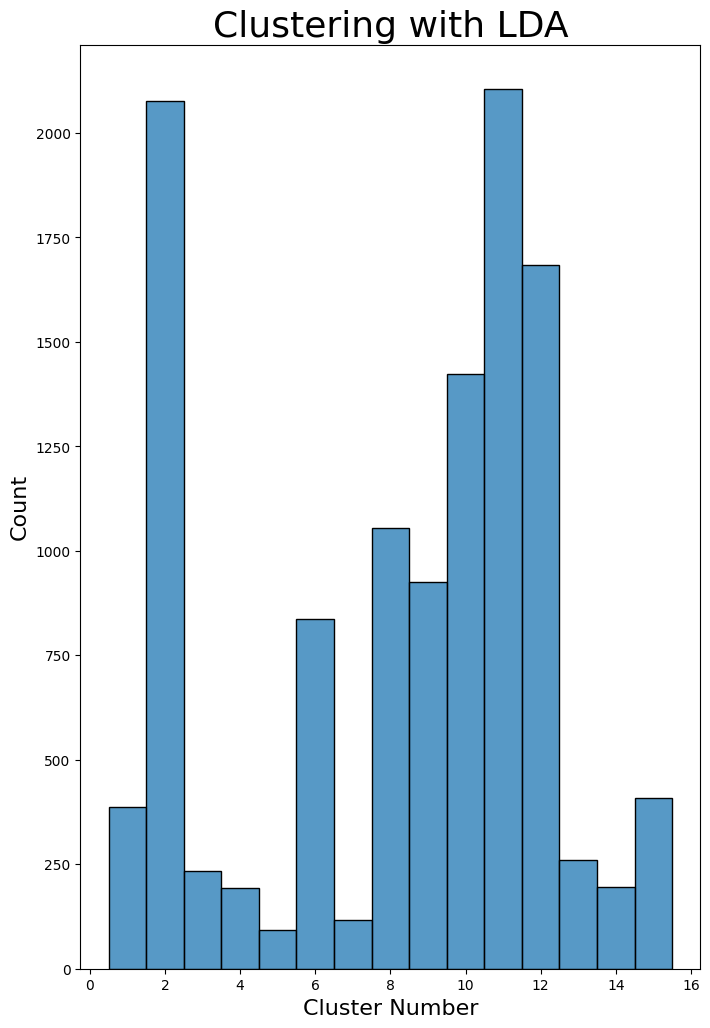

In [75]:
topic = [np.argmax(values)+1 for values in lda_features]
topic = pd.DataFrame({'Clusters' : topic})

plt.figure(figsize=(8,12)).clf()
sns.histplot(topic, bins = true_k, x = 'Clusters', discrete = True)
plt.title('Clustering with LDA',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

LDA z pozoru daje lepsze wyniki, ponieważ zamiast jednego dużego klastra jak w NMF jest kilka większych. Odrzucamy je jednak, ponieważ ma skłonności do tworzenia małych i słabo interpretowalnych klastrów. Widać to po słowach kluczowych dla klastrów 5, 7 i 14.

## Redukcja po SVD

In [76]:
svd = TruncatedSVD(n_components=true_k, random_state=42)
svd.fit(tf_idf)
svd_features = svd.transform(tf_idf)
get_topics(svd,true_k,used_words)

,0,1,2,3,4,5,6,7,8,9
Topic # 01,year,good,want,look,anyon,right,window,new,thank,problem
Topic # 02,window,thank,file,card,drive,program,mail,run,pleas,anyon
Topic # 03,game,team,play,player,year,win,fan,season,hit,leagu
Topic # 04,window,god,game,file,christian,run,program,jesu,team,win
Topic # 05,god,drive,christian,thank,pleas,jesu,mail,mb,card,car
Topic # 06,mail,pleas,thank,email,anyon,post,inform,address,phone,send
Topic # 07,car,window,bike,look,thank,good,ride,dod,mile,engin
Topic # 08,key,car,chip,god,encrypt,bit,good,bike,phone,thing
Topic # 09,card,driver,monitor,video,bu,color,bit,board,graphic,mode
Topic # 10,object,valu,moral,space,scienc,year,univers,imag,comput,book


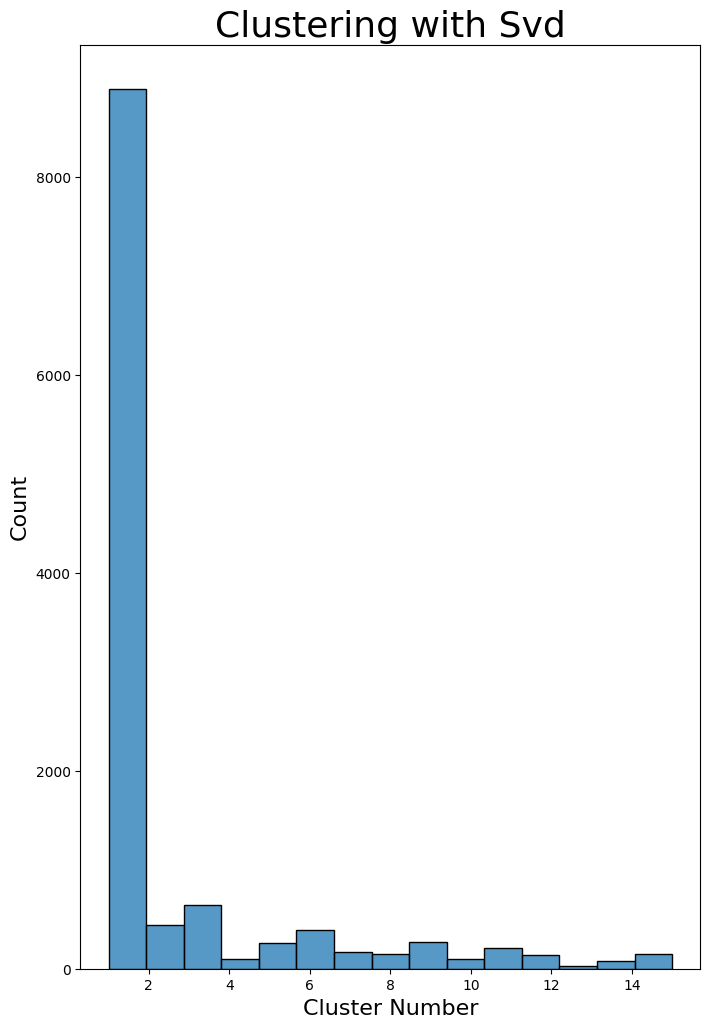

In [77]:
topic = [np.argmax(values)+1 for values in svd_features]
plt.figure(figsize=(8,12)).clf()
topic = pd.DataFrame({'Clusters' : topic})
sns.histplot(topic, bins = true_k, x = 'Clusters')
plt.title('Clustering with Svd',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

## Zatem NMF radzi sobie najlepiej z rozbijaniem na wmiare równomierne klastry. Czy warto robić na tym klasyczne klastrowanie?

In [78]:
km = KMeans(n_clusters = 15)
km.fit(features)
labels = km.predict(features)

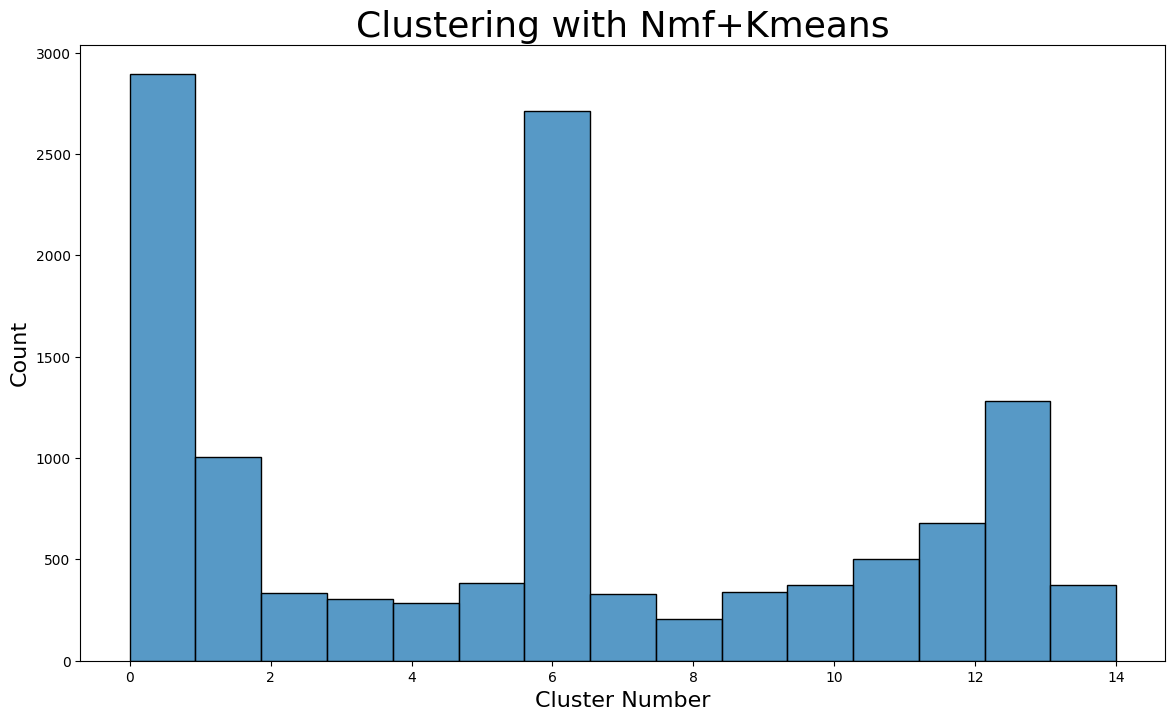

In [79]:
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels, bins = 15)
plt.title('Clustering with Nmf+Kmeans',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

Nie dość, że przy tym tracimy na interpretowalności to uwydatnia się problem z jednym dużym klastrem

## Lepiej działa klastrowanie wokół nowych osi. Jaka liczba klastrów będzie najlepsza?

In [80]:
scores = []  
cluster_num_iter = range(5,36,1)

# ta sama metoda którą używaliśmy przy pierwszym KMeans
for k in cluster_num_iter:
    model = NMF(n_components = k, init = 'nndsvda', max_iter = 1000, random_state = 42)
    model.fit(tf_idf)
    nmf_features = model.transform(tf_idf)
    topic = [np.argmax(values)+1 for values in nmf_features]
    wcss = silhouette_score(tf_idf, topic)
    scores.append(wcss)

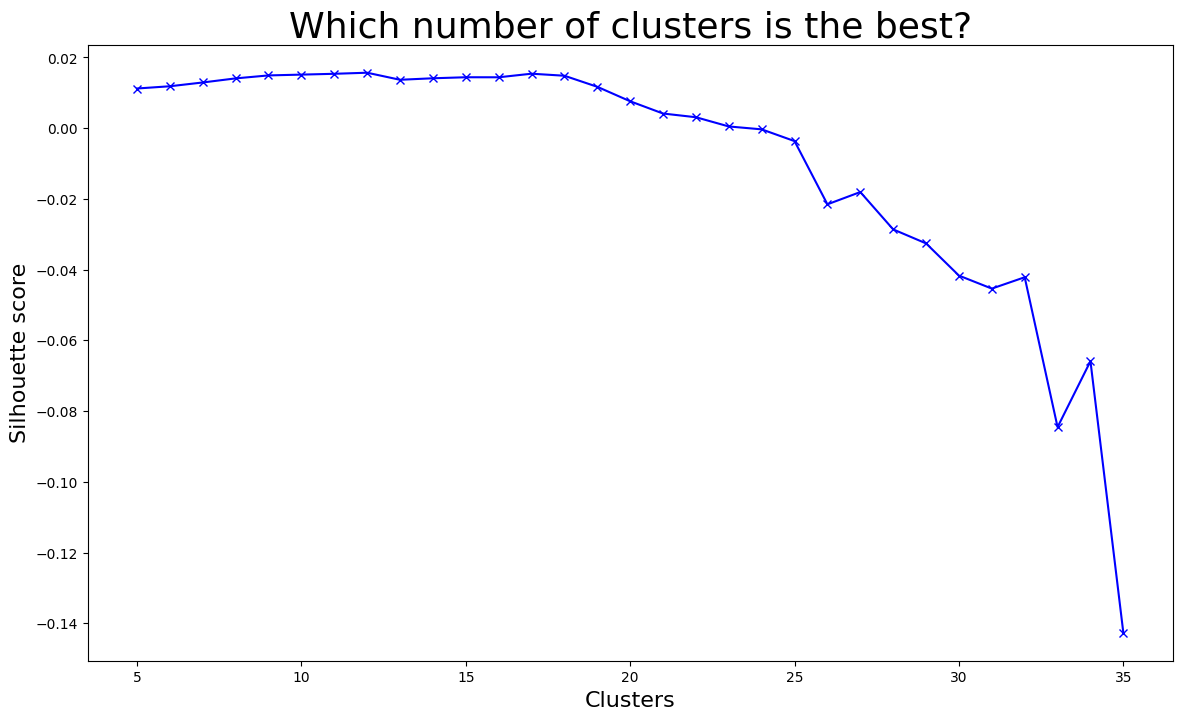

In [81]:
plt.figure(figsize=(14,8)).clf()
plt.plot(cluster_num_seq, scores, 'bx-')
plt.title("Which number of clusters is the best?",fontsize=26)
plt.xlabel('Clusters',fontsize=16)
plt.ylabel('Silhouette score',fontsize=16)
plt.show()

# Implementacja
Widzimy, że 12 jest niezłym kandydatem na ogólniejszy clustering, a dla szczególniejszego przypadku to 25

In [82]:
def Implement(tf_idf, words, model, true_k, y):
    
    model.fit(tf_idf)
    df_topic = get_topics(model,true_k,words,15)
    
    features = model.transform(tf_idf)
    
    topic = [np.argmax(values)+1 for values in features]
    df = pd.DataFrame({'topic': topic, 'category': y})
    cross_tab = pd.crosstab(df['topic'], df['category']).T
    cross_tab = cross_tab.apply(lambda row : round(100*row/sum(row), 2), axis = 1)
    
    plt.figure(figsize=(14,8)).clf()
    topic = pd.DataFrame({'Cluster Number' : topic})
    plot = sns.histplot(topic, bins = true_k, x = 'Cluster Number', discrete = True)
    plt.ylabel('Count',fontsize=16)
    plt.xlabel('Cluster Number',fontsize=16)
    plt.title('Clustering with Nmf on train',fontsize=26)
    
    return df_topic, cross_tab, plot, model

In [83]:
# np.argmax(scores)+5 
# Trzeba za każdym razem liczyc Silhouette score, więc darujmy sobie. Zawsze wychodzi 12

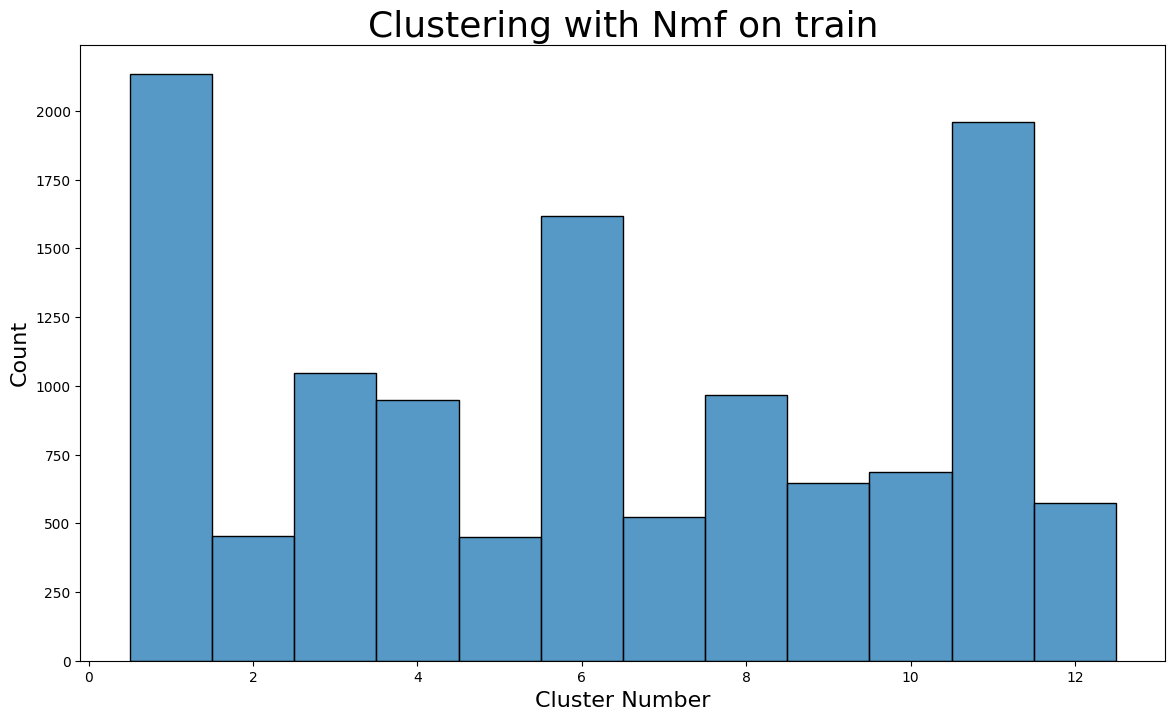

In [84]:
true_k = 12
model = NMF(n_components = true_k, init = 'nndsvda', max_iter = 500, random_state = 42)
topics, cross_tab, plot, final_model = Implement(tf_idf, used_words, model,true_k, y_train)

In [85]:
topics

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic # 01,right,govern,gun,state,law,said,kill,year,israel,child,fbi,day,want,thing,happen
Topic # 02,window,run,applic,problem,program,manag,version,server,screen,memori,driver,user,set,win,display
Topic # 03,game,team,play,win,player,fan,year,season,hit,leagu,watch,run,goal,seri,good
Topic # 04,god,christian,jesu,believ,bibl,christ,faith,church,love,religion,belief,exist,life,word,hell
Topic # 05,drive,disk,hard,mb,control,problem,format,mac,instal,set,switch,speed,intern,need,power
Topic # 06,thank,pleas,mail,anyon,advanc,email,post,appreci,repli,help,hi,address,look,inform,someon
Topic # 07,key,chip,encrypt,secur,phone,bit,govern,public,number,data,messag,devic,law,commun,need
Topic # 08,car,bike,good,look,engin,speed,ride,dod,mile,buy,road,light,thing,realli,got
Topic # 09,card,driver,video,monitor,bit,bu,color,mb,board,mode,graphic,problem,ram,control,pc
Topic # 10,file,program,imag,format,ftp,convert,graphic,color,read,display,disk,bit,code,tri,help


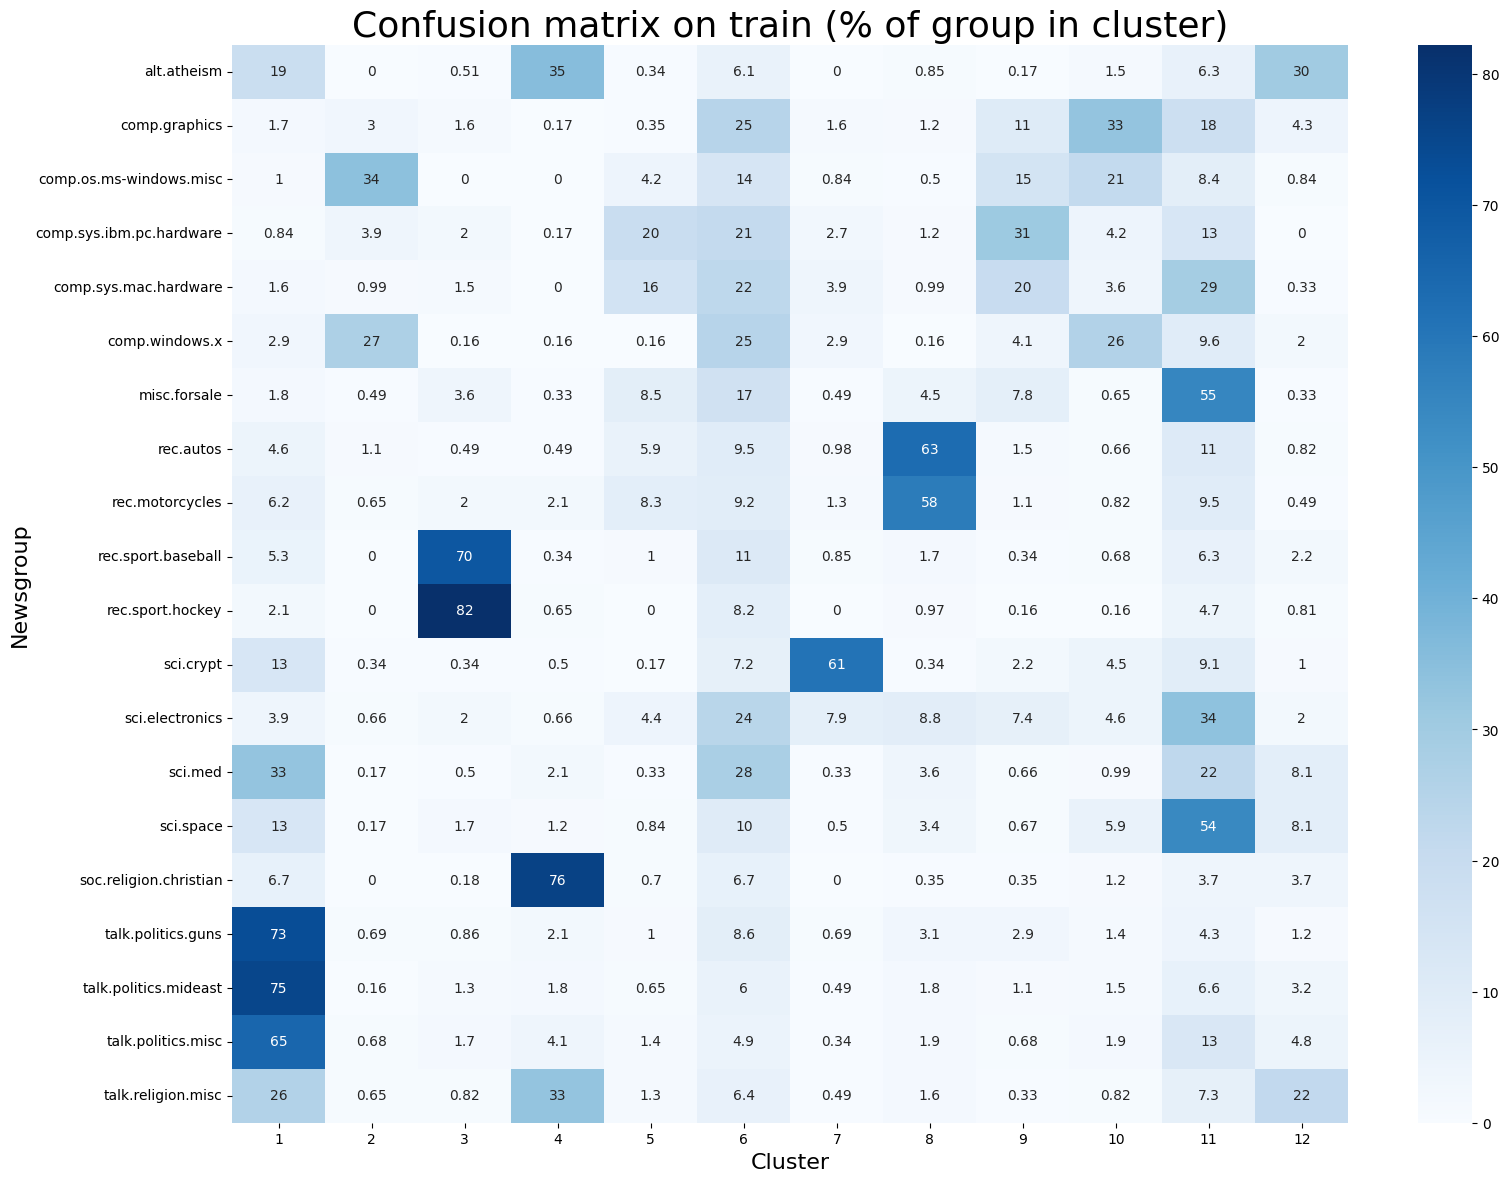

In [86]:
plt.figure(figsize=(18,14)).clf()
sns.heatmap(cross_tab, annot = cross_tab, cmap='Blues')
plt.ylabel('Newsgroup', fontsize=16)
plt.yticks(rotation=0)
plt.xlabel('Cluster', fontsize=16)
plt.title("Confusion matrix on train (% of group in cluster)", fontsize=26)
plt.show()

## Wdrożenie testu

In [87]:
tf_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = tf_idf.columns)

In [88]:
# Model ma być wytrenowany już w tej funkcji
def CheckTest(model, tf, true_k, y):
    
    features = model.transform(tf)
    
    topic = [np.argmax(values)+1 for values in features]
    df = pd.DataFrame({'topic': topic, 'category': y})
    
    cross_tab = pd.crosstab(df['topic'], df['category']).T
    # Taki sam cross_tab jak ostatnio tylko teraz z procentami zamiast liczb
    cross_tab = cross_tab.apply(lambda row : round(100*row/sum(row), 2), axis = 1)
    
    plt.figure(figsize=(14,8)).clf()
    topic = pd.DataFrame({'Cluster Number' : topic})
    plot = sns.histplot(topic, bins = true_k, x = 'Cluster Number', discrete = True)
    plt.ylabel('Count',fontsize=16)
    plt.xlabel('Cluster Number',fontsize=16)
    plt.title('Clustering with Nmf on test',fontsize=26)

    return cross_tab, plot

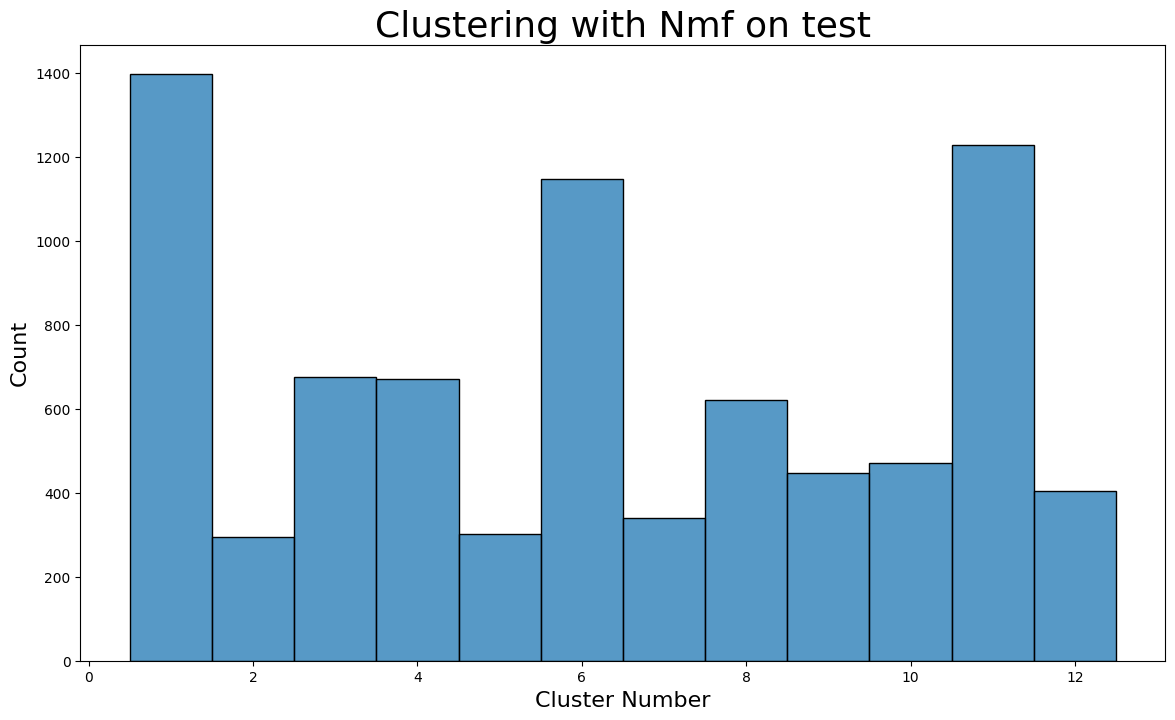

In [89]:
cross_tab, hist_plot = CheckTest(final_model, tf_test, true_k, y_test)

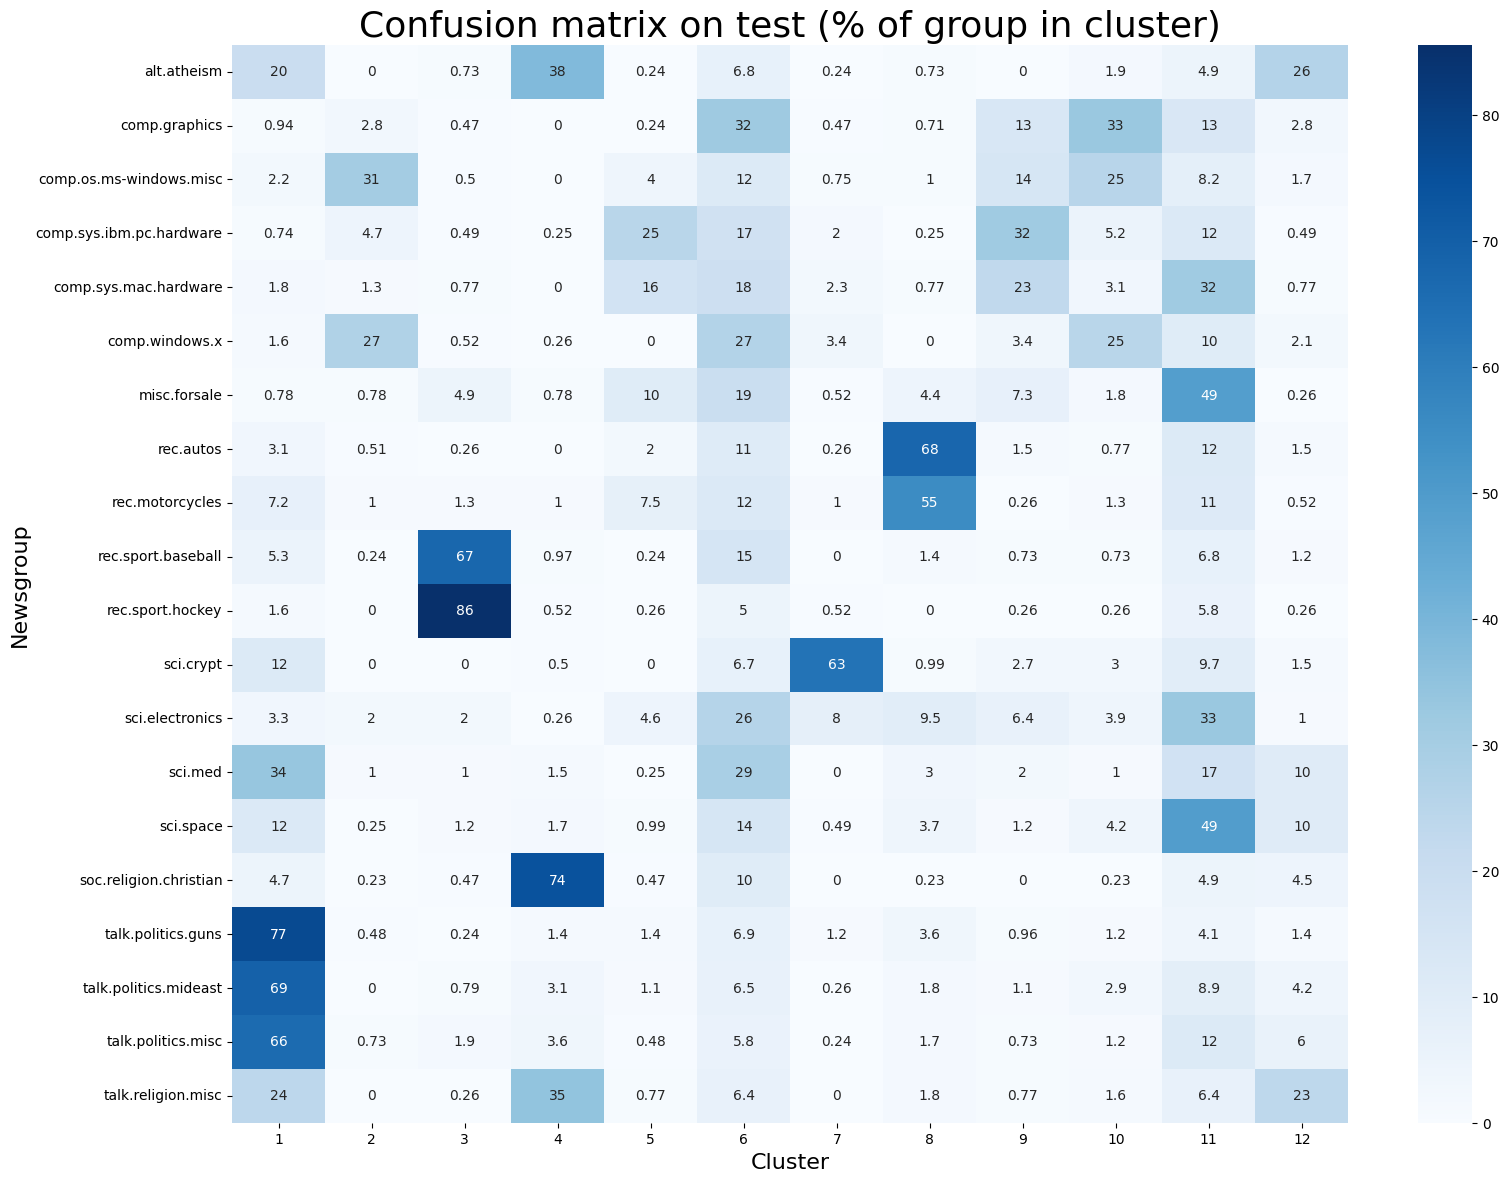

In [90]:
plt.figure(figsize=(18,14)).clf()
sns.heatmap(cross_tab, annot = cross_tab, cmap='Blues')
plt.ylabel('Newsgroup', fontsize=16)
plt.yticks(rotation=0)
plt.xlabel('Cluster', fontsize=16)
plt.title("Confusion matrix on test (% of group in cluster)", fontsize=26)
plt.show()

## Spróbujmy znaleźć tematy dla ograniczonego zbioru do grup polityczno-religijnych

In [91]:
limited = ['talk.politics.misc',
            'talk.politics.guns',
            'talk.politics.mideast',
            'talk.religion.misc',
            'alt.atheism',
            'soc.religion.christian']

data_l = [text for text, group in zip(X_train, y_train) if group in limited]
y_l = [group for group in y_train if group in limited]

In [92]:
tf_idf_l, vectorizer_l = Tf_idf(data_l)
used_words_l = vectorizer_l.get_feature_names_out()

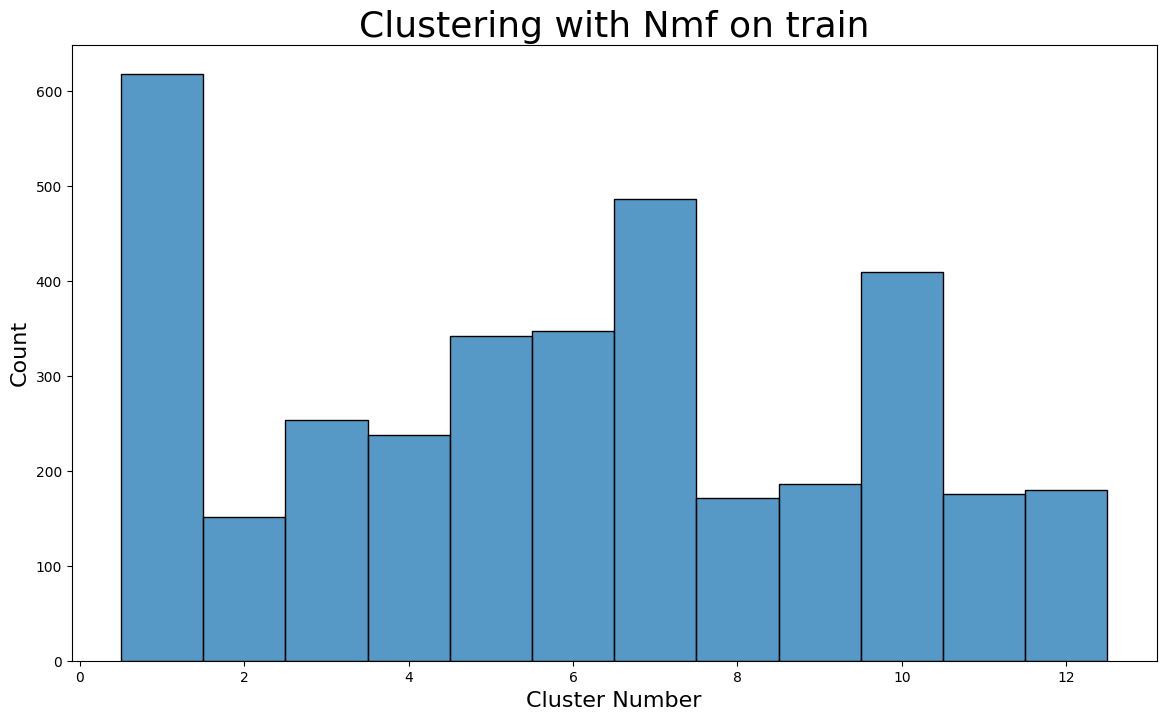

In [93]:
topics_l, cross_tab_l, plot_l, final_model_l = Implement(tf_idf_l, used_words_l, model, 12, y_l)

In [94]:
topics_l

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic # 01,post,book,read,question,claim,pleas,someth,atheist,exist,reason,argument,evid,year,answer,ask
Topic # 02,armenian,turkish,armenia,turk,turkey,soviet,genocid,extermin,russian,serdar,mountain,villag,argic,massacr,road
Topic # 03,christian,church,religion,faith,belief,christ,bibl,atheist,cathol,truth,teach,follow,understand,religi,scriptur
Topic # 04,moral,object,valu,frank,dwyer,uucp,better,scienc,jon,truth,realiti,absolut,observ,keith,subject
Topic # 05,israel,arab,isra,palestinian,jew,jewish,peac,kill,territori,occupi,land,attack,civilian,war,polici
Topic # 06,gun,law,weapon,firearm,govern,control,crimin,crime,polic,arm,amend,carri,legal,kill,car
Topic # 07,fbi,koresh,batf,bd,compound,ga,atf,child,start,govern,davidian,agent,cult,burn,build
Topic # 08,theori,scienc,evolut,creation,religion,observ,exist,predict,andi,univers,earth,creat,origin,explain,scientif
Topic # 09,abort,insur,pay,health,tax,privat,care,fund,money,servic,reduc,clinton,cost,american,program
Topic # 10,jesu,sin,christ,heaven,love,hell,lord,etern,die,bibl,life,john,father,man,son


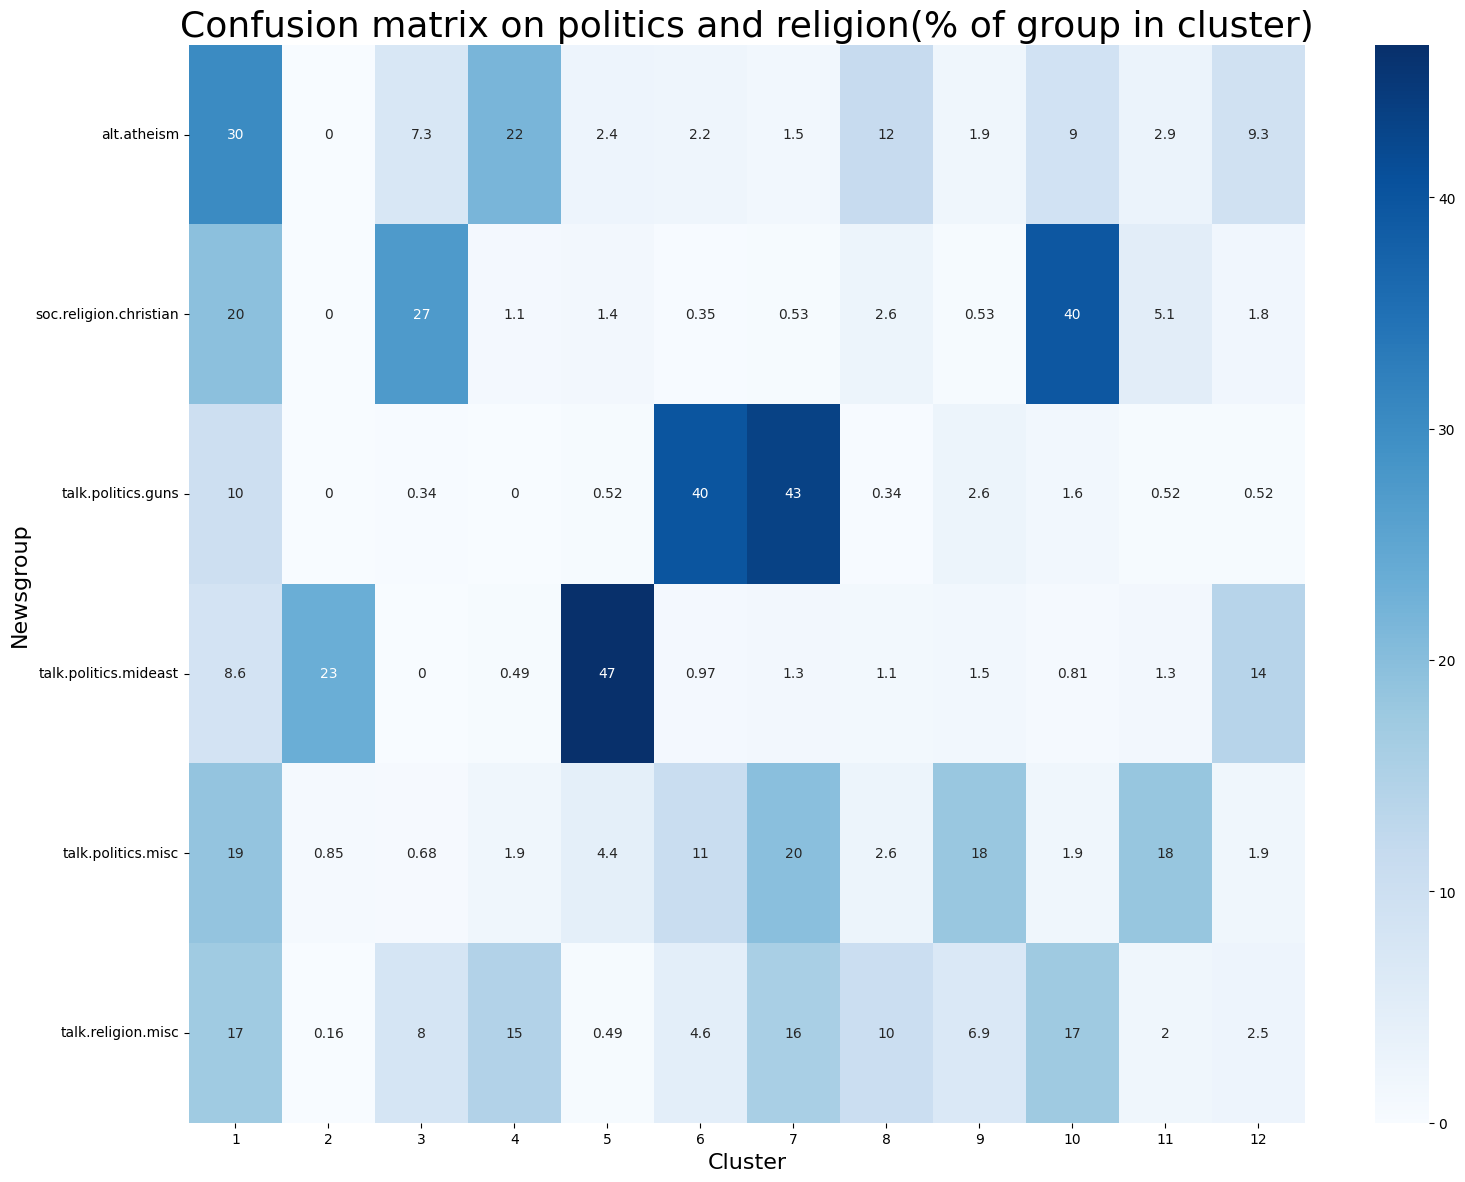

In [95]:
plt.figure(figsize=(18,14)).clf()
sns.heatmap(cross_tab_l, annot = cross_tab_l, cmap='Blues')
plt.ylabel('Newsgroup', fontsize=16)
plt.yticks(rotation=0)
plt.xlabel('Cluster', fontsize=16)
plt.title("Confusion matrix on politics and religion(% of group in cluster)", fontsize=26)
plt.show()

## Będziemy jeszcze robić cloud of words

In [96]:
def cloud_of_words(tf_idf,true_k, index):
    model = NMF(n_components = true_k, init = 'nndsvda', max_iter = 500, random_state = 42)
    model.fit(tf_idf)
    num_topics = true_k
    n_top_words = 30
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names_out()
    
    word_list = []
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [(feat_names[key], model.components_[i][key]) for key in words_ids]
        word_list.append(words)
    wordcloud = WordCloud(width=3000,
                            height=2000,
                            random_state=123,
                            background_color="white")
    wordcloud.generate_from_frequencies(dict(word_list[index]))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

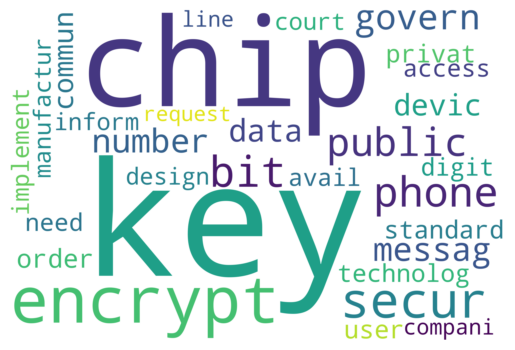

In [97]:
# ta funkcja służy do twozenia wordcloudów dla wybranego klastra 
# (w tym przypadku liczba klastrow = 22 i z nich wybieramy 7 klaster)
cloud_of_words(tf_idf,22, 7)